In [1]:
import pandas as pd
import numpy as np
import re
import os

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [40]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, cohen_kappa_score, r2_score
from sentence_transformers import SentenceTransformer

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import optuna
import language_tool_python

In [5]:
from imblearn.over_sampling import SMOTE
from textstat import flesch_kincaid_grade
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import textstat
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import RobertaTokenizer, RobertaModel

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [8]:
nltk.data.path.append(os.path.abspath('nltk_data'))

In [9]:
nltk.download('punkt_tab', download_dir='nltk_data')
nltk.download('omw-1.4', download_dir='nltk_data')
nltk.download('stopwords' , download_dir='nltk_data')
nltk.download('wordnet' , download_dir='nltk_data')
nltk.download('averaged_perceptron_tagger_eng' , download_dir='nltk_data')

[nltk_data] Downloading package punkt_tab to nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

---


In [10]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', encoding='latin1')
    df = df[['essay_id', 'essay_set', 'essay', 'domain1_score']].dropna()
    return df

In [11]:
    essays = load_data('../Dataset/asap-aes/training_set_rel3.tsv')

- essay_id: A unique identifier for each individual student essay
- essay_set: 1-8, an id for each set of essays
- essay: The ascii text of a student's response
- rater1_domain1: Rater 1's domain 1 score; all essays have this
- rater2_domain1: Rater 2's domain 1 score; all essays have this
- rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
- domain1_score: Resolved score between the raters; all essays have this
- rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
- rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
- domain2_score: Resolved score between the raters; only essays in set 2 have this
- rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8


---


# Preprocess


In [ ]:
class EssayPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english') )
        self.lemmatizer = WordNetLemmatizer()
        self.grammar_tool = language_tool_python.LanguageTool('en-US')
        self.sbert = SentenceTransformer('all-mpnet-base-v2')
        
    def preprocess_text(self, text):
        # Basic cleaning
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        # Tokenization and stopword removal
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words]
        
        # Lemmatization with POS tagging
        pos_tags = nltk.pos_tag(tokens)
        lemmatized = []
        for word, tag in pos_tags:
            if tag.startswith('V'):  # Verb
                lemmatized.append(self.lemmatizer.lemmatize(word, 'v'))
            elif tag.startswith('J'):  # Adjective
                lemmatized.append(self.lemmatizer.lemmatize(word, 'a'))
            elif tag.startswith('R'):  # Adverb
                lemmatized.append(self.lemmatizer.lemmatize(word, 'r'))
            else:  # Noun
                lemmatized.append(self.lemmatizer.lemmatize(word))
                
        return ' '.join(lemmatized)
    
    def extract_linguistic_features(self, text):
         # Grammar and spelling
        matches = self.grammar_tool.check(text)
        grammar_errors = len(matches)
        
        # Readability
        readability = flesch_kincaid_grade(text)
        
        
        # Vocabulary richness
        words = word_tokenize(text)
        unique_words = set(words)
        vocab_richness = len(unique_words) / max(1, len(words))
        
        # Essay structure
        sentences = nltk.sent_tokenize(text)
        avg_sentence_len = sum(len(word_tokenize(s)) for s in sentences) / max(1, len(sentences))
        
        return {
            'grammar_errors': grammar_errors,
            'readability': readability,
            'vocab_richness': vocab_richness,
            'avg_sentence_len': avg_sentence_len
        }
    
    def get_sbert_embedding(self, text):
        return self.sbert.encode(text, show_progress_bar=False)

In [13]:
preprocessor = EssayPreprocessor()

In [14]:
preprocessor

In [15]:
essays['processed_text'] = essays['essay'].apply(preprocessor.preprocess_text)
essays['processed_text']


0        dear local newspaper think effect computer peo...
1        dear cap cap believe use computer benefit u ma...
2        dear cap cap cap people use computer everyone ...
3        dear local newspaper cap find many expert say ...
4        dear location know computer positive effect pe...
                               ...                        
12971    story mother daughter either enemy friends cap...
12972    never understood meaning laughter short distan...
12973    laugh cap habit cap cause cause laugh cap even...
12974    trippin fence num year young short num year ev...
12975    many people believe laughter improve life laug...
Name: processed_text, Length: 12976, dtype: object

In [16]:
linguistic_features = essays['processed_text'].apply(preprocessor.extract_linguistic_features)
linguistic_df =  pd.json_normalize(linguistic_features)

In [32]:
print("Generating SBERT embeddings...")
sbert_embeddings = np.array(essays['processed_text'].apply(preprocessor.get_sbert_embedding).tolist())
sbert_df = pd.DataFrame(sbert_embeddings)

Generating SBERT embeddings...


In [33]:
X = pd.concat([linguistic_df, sbert_df], axis=1)
y = essays['domain1_score']

---


In [34]:
class AESModel(nn.Module):
    def __init__(self, input_dim):
        super(AESModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc_out(x)

In [ ]:
def train_model(X_train, y_train, params):

    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    model = AESModel(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    

    for epoch in range(params['epochs']):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    return model

In [42]:

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test.values)
        predictions = model(X_test_tensor).squeeze().numpy()

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    return {
        'predictions': predictions,
        'mse': mse,
        'rmse': rmse,
        'r2': r2  
    }

In [ ]:
def objective(trial):
    
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'epochs': trial.suggest_int('epochs', 20, 100),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    }
    
    kf = KFold(n_splits=5)
    rmse_scores = []  
    r2_scores = []  
    

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
   
        model = train_model(X_train, y_train, params)
      
        metrics = evaluate_model(model, X_val, y_val)
        
  
        rmse_scores.append(metrics['rmse'])
        r2_scores.append(metrics['r2'])

    return np.mean(rmse_scores,r2_scores)


In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-04-23 19:34:33,810] A new study created in memory with name: no-name-a6d66b87-1597-4d67-8be8-b95de3464ec5
[I 2025-04-23 19:40:19,446] Trial 0 finished with value: 6.2471532523616755 and parameters: {'lr': 4.446702377955076e-05, 'batch_size': 64, 'epochs': 99, 'weight_decay': 0.00029346669096906694}. Best is trial 0 with value: 6.2471532523616755.
[I 2025-04-23 19:43:04,490] Trial 1 finished with value: 6.014880583328812 and parameters: {'lr': 1.4094579813970973e-05, 'batch_size': 32, 'epochs': 29, 'weight_decay': 2.451270217422442e-05}. Best is trial 0 with value: 6.2471532523616755.
[I 2025-04-23 19:45:05,087] Trial 2 finished with value: 6.271676776160589 and parameters: {'lr': 3.715849054988805e-05, 'batch_size': 32, 'epochs': 21, 'weight_decay': 4.558388547117818e-05}. Best is trial 2 with value: 6.271676776160589.
[I 2025-04-23 19:56:13,568] Trial 3 finished with value: 6.13661883339618 and parameters: {'lr': 3.8320215402036105e-05, 'batch_size': 16, 'epochs': 63, 'weight_

Best hyperparameters: {'lr': 3.715849054988805e-05, 'batch_size': 32, 'epochs': 21, 'weight_decay': 4.558388547117818e-05}


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:

final_model = train_model(X_train, y_train, best_params)

results = evaluate_model(final_model, X_test, y_test)

In [65]:
print("\nFinal Evaluation Results:")
print(f"Mean Squared Error (MSE): {results['mse']:.4f}")
print(f"Root Mean Squared Error (RMSE): {results['rmse']:.4f}")
print(f"R-squared (R2): {results['r2']:.4f}")



Final Evaluation Results:
Mean Squared Error (MSE): 6.0017
Root Mean Squared Error (RMSE): 2.4498
R-squared (R2): 0.9229


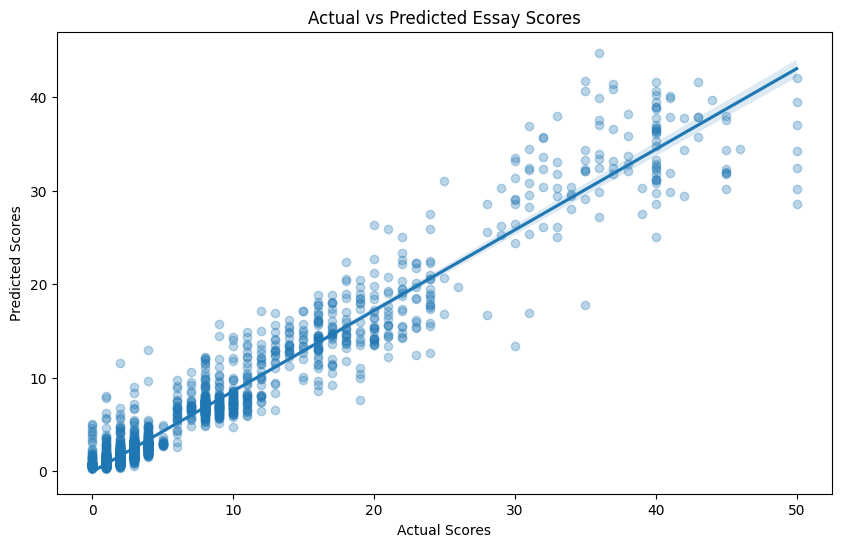

In [63]:
## 7. Visualization and Analysis
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=results['predictions'], scatter_kws={'alpha':0.3})
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Essay Scores')
plt.show()



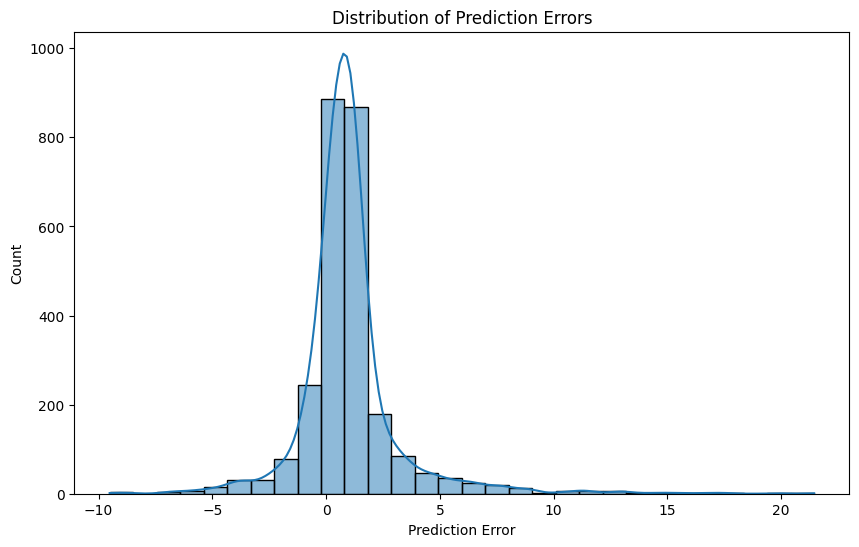

In [64]:
# Error analysis
errors = y_test - results['predictions']
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.show()

---


In [ ]:
pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:

essay_data = pd.read_excel('../Dataset/asap-aes/Essay_Set_Descriptions/Essay_Set_Descriptions/essay_set_descriptions.xlsx')

def preprocess_new_essay(essay, essay_set_id):
    processed_text = preprocessor.preprocess_text(essay)
    linguistic_features = preprocessor.extract_linguistic_features(processed_text)
    
    sbert_embedding = preprocessor.get_sbert_embedding(processed_text)
    
    linguistic_df = pd.json_normalize(linguistic_features)
    sbert_df = pd.DataFrame([sbert_embedding])
    
    X_new = pd.concat([linguistic_df, sbert_df], axis=1)
    
    essay_set_info = essay_data[essay_data['essay_set'] == essay_set_id]
    min_score = essay_set_info['min_domain1_score'].values[0]
    max_score = essay_set_info['max_domain1_score'].values[0]
    
    return X_new, min_score, max_score

def predict_essay_score(essay, model, essay_set_id):
    X_new, min_score, max_score = preprocess_new_essay(essay, essay_set_id)
    
    X_new_tensor = torch.FloatTensor(X_new.values)
    
    model.eval()
    with torch.no_grad():
        predicted_score = model(X_new_tensor).item() 
    
    normalized_predicted_score = (predicted_score - min_score) / (max_score - min_score)
    
    final_predicted_score = normalized_predicted_score * (max_score - min_score) + min_score
    
    return final_predicted_score

new_essay = """and sometimes even airports, have @ORGANIZATION1 covers on the front to visually censor the front page of the magazine. Movies are given ratings based on their level of explicit material, and when shown on basic cable, they sometimes can have either silenced words, or more appropriate words brought in to fit the dialougue in the movie. Books, although very rarely, have been banned from libraries and censored from the entire world. Some books have been previously censored, but became uncensored and brought back to libraries. In my opinion, censorship should not be based on a single person's view of the material, but rather on the viewpoint of the public. Growing up, my parents would watch carefully about what shows I watched, what music I listened to, or the types of magazines that i looked at.     When I was growing up, I loved to watch professional wrestling. I loved to watch big scary guys as tall as seven feet hitting each other with steel chairs, crashing each other into tables, or throwing each other off of twenty-foot steel cages. My brother and I used to have a favorite wrestler that we would for every week, @PERSON1 @CAPS1 could freighten any other wrestler who stood in his way. My brother and I loved to watch @PERSON1 @CAPS1 compete every week for a chance at a world chamionship belt. As time passed, professional wrestling began to welcome in beautiful women into their business. These women would come out onto the ring with tight, shiny, lingerie on as they became eye-candy for the men who watched professional wrestling. One day, I'm watching two girls fighting in a match when my mom walks in. She takes one look at the half-naked girls fighting each other and turns off the @CAPS3 and declares that professional wrestling is too adult for me. Even though I was twelve at the time, I didn't want to get in an argument with my mom about how much I should be allowed to see. Censorship can be based on the ideas and viewpoints of the parents and guardians.     I was in grade school when I fell in love with the show, '@CAPS4 @CAPS5 @CAPS6.' @CAPS7 is a show about four boys who go on unintentional adventures to save their @CAPS4 @CAPS5. These four boys, who are all around eleven years old, use curse words that some adults would be afraid to use in every day life. Their behavior is very controversial and the show itself has been forced to ban a few of their episodes for safety reasons. One problem with @CAPS7 show was that my dad loved @CAPS7 show as well, and tried to get my mom to like the show. When my mom saw the show, she immediately banned me from watching it because of its explicit content. Now that I am older, I am able to make my own decisions about what I watch, but as a kid, my parents decided what was appropriate for me.     I grew up listening to several different types of music. My brother listened to rap, alternative, and even songs that were in musicals because he was in show choir. My dad introduced me to classic rock, and my mom loved soft rock. Although I didn't necessarily like the music that my mom liked, I learned to love my dad's music and my brother's music. I loved to listen to music from artists like @ORGANIZATION4, @ORGANIZATION1, @LOCATION1, @ORGANIZATION3, @CAPS8, @CAPS9, and so on. My musical tastes branched out into a variety of different genres. One day, I'm walking in the hallway when I hear some music coming from the living room. I go to see what is playing because it sounds unfamiliar. My dad and my brother told me to go into another room and not listen to the music. The song was by a band named @ORGANIZATION2. Even though it might seem unfair, censorship, given by the parents and guardians, is very necessary.     Although some people might find a certain piece of material offensive, it doesn't mean that the entire world should be banned from the material itself. If that person wants to keep away from the material and keep their kids from seeing or listening to that material, they are able to do that. Censorship, given by the parents or guardians, is the best way to view censorship. Nothing should be banned from a library, music store, or any other place that sells these materials. Censorship is important, but the entire banning of a certain piece of material is unjust."""

essay_set_id = 2  


predicted_score = predict_essay_score(new_essay, final_model, essay_set_id)

print("Predicted Essay Score:", predicted_score)

Predicted Essay Score: 4.7871785163879395
